# Set-valued prediction based on utility maximization 

In [3]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from itertools import chain, combinations

<div align="justify">


In line with classical statistics, but unlike decision theory and machine learning, the setting of conformal prediction does not involve any notion of loss function. In this regard, it differs from methods for set-valued prediction based on utility maximization (or loss minimization), which are primarily used for multi-class classification problems. Similar to conformal prediction, such methods also return a set of classes when the classifier is too uncertain with respect to the class label to predict, but the interpretation of this set is different. Instead of returning a set that contains the true class label with high probability, sets that maximize a set-based utility score are sought. Besides, being based on the conditional distribution $ \prob(y\,|\,\vec{x}_q) $ of the outcome $ y $ given a query $ \vec{x}_q $, most of these methods capture *conditional* uncertainty. 

Let $u(y,\sety)$ be a set-based utility score, where $y$ denotes the ground truth outcome and $\sety$ the predicted set. Then, adopting a decision-theoretic perspective, the Bayes-optimal solution $\sety^{*}_u$ is found by maximizing the following objective:

$$
\sety^{*}_u(\vec{x}_q) = \argmax_{\sety \in 2^{\mathcal{Y}}\setminus \{\emptyset\}} \evalue_{p(y\,|\,\vec{x}_q)} \big( u(y,\sety) \big) = \argmax_{\sety \in 2^{\mathcal{Y}}\setminus \{\emptyset\}} \sum_{y \in \mathcal{Y}} u(y,\sety) \, p(y\,|\,\vec{x}_q) \,.
$$(bayesoptimal)

Solving {eq}`bayesoptimal` as a brute-force search requires checking all subsets of $\mathcal{Y}$, resulting in an exponential time complexity.
Assuming we have four classes as in the figure below and we are interested in predicting the set of the new point $\vec{x}_q$.

</div>

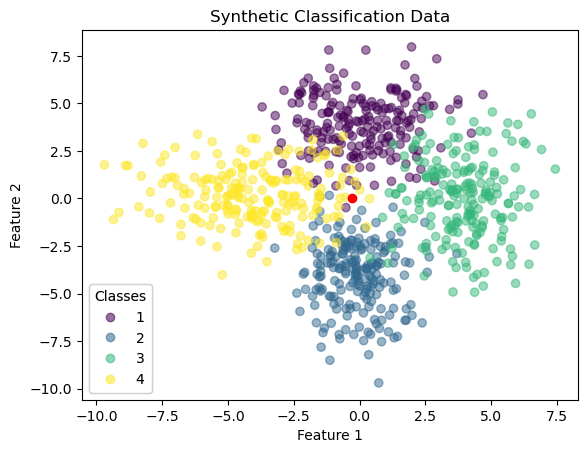

In [4]:
def build_possible_prediction_sets(classes):
    "build_possible_prediction_sets([1,2]) → (True,False) (False,True) (True,True)"
    power_set = list(chain.from_iterable(combinations(classes, r) for r in range(1,len(classes)+1)) ) # powerset without the empty set
    masked_power_set = np.array([
        [i in set for i in classes]
        for set in power_set
    ])
    
    return masked_power_set # we start with 1 to not have the empty set contained

def masked_set_to_prediction_set(masked_set, classes):
    prediction_sets = [
        classes[mask] for mask in masked_set
    ]
    return prediction_sets


def plot_synthetic_data(ax,X,y, new_point, title):
    ax.set_title(title)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, alpha=.5)
    if new_point is not None:
        ax.scatter(*new_point, c="r")

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
    ax.add_artist(legend1)

    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


n_samples = 200
n_classes = 4
classes = np.array(list(range(1,n_classes+1)))
random_state = 41

# parameters for toy data
means = [(0,4),(0,-4),(4,0),(-4,0)]
covs = [np.eye(2)*2.5,np.diag([1.5,2.8]), np.diag([1.5,4.5]), np.diag([3.8,2])]

np.random.seed(random_state)

X = np.vstack([
    np.random.multivariate_normal(mean,cov,n_samples) 
    for mean,cov in zip(means,covs)
])
y = np.hstack([np.full(n_samples,i) for i in classes])

x_q = np.array([-.3, 0])

fig, ax = plt.subplots()

plot_synthetic_data(ax,X,y,x_q,"Synthetic Classification Data")

plt.show()

We firstly must train an classification model on the data, here we choose the [Gaussian Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html), through which we construct the conditional probability $p(y\,|\,\vec{x}_q)$.

In [5]:
gaussian_model = GaussianNB()
gaussian_model.fit(X,y)
conditional_probability_query_point = gaussian_model.predict_proba(x_q.reshape(1,-1))
for i in classes:
    print(f"P(y = {i} | x_q) = {round(conditional_probability_query_point[0][i-1], 3)}")

P(y = 1 | x_q) = 0.122
P(y = 2 | x_q) = 0.31
P(y = 3 | x_q) = 0.022
P(y = 4 | x_q) = 0.547


<div align="justify">

To predict the set $\sety$ we must iterate over all possible $\sety \in 2^{\mathcal{Y}}\setminus \{\emptyset\}$ to construct the prediction interval. 
We choose as utility score 

$$

u(y,\sety) = \left \{ 
\begin{array}{cl}
0 &\quad \mbox{if $y \notin \sety$} \ \\
\frac{2}{ (1 + |\sety| }&\quad \mbox{if $y \in \sety$} 
\end{array} \, ,
\right.

$$

which represents the well-known notion of $F_1$-measure ({cite:p}`delc_ln09`).
Intuitively it gives a reward of 0, if the true label is not contained in the prediction set and penalizes bigger sets over smaller ons.
Especially for $|\sety| = 1$ the utility score is maximized, i.e. $u(y,\sety) = 1$ .
A more general formulation of $u(y,\sety)$ will be later on introduced.


</div>


In [6]:
def utility_function(contained_function,y,set_prediction):
    if y in set_prediction:
        return contained_function(len(set_prediction))
    else:
        return 0
    

def build_masked_prediction_set(utility_score, classes, conditional_probability):
    n_samples,n_classes = conditional_probability.shape
    
    masked_prediction_set = build_possible_prediction_sets(classes) # instead of sets we have boolean values indicating whether the class is contained in the possible prediction set
    
    max_value,set_prediction = np.zeros(n_samples,dtype=np.float64), np.zeros((n_samples,n_classes),dtype=bool)
    # iterate over all possible prediction_sets
    for masked_sets in masked_prediction_set: 
        # build the averaged score the prediction set achieves given the conditional probability
        averaged_utility = np.sum(np.array([utility_score(y,classes[masked_sets]) for y in classes]) * conditional_probability, axis=-1)
        # find the max_value and set_prediction
        
        mask = max_value < averaged_utility
        
        max_value[mask] = averaged_utility[mask]
        set_prediction[mask] = masked_sets
            
    return set_prediction

def build_prediction_set(utility_score, classes, conditional_probability):
    masked_prediction_set = build_masked_prediction_set(utility_score, classes, conditional_probability) 
    prediction_set = masked_set_to_prediction_set(masked_prediction_set, classes)
    return prediction_set


def f1_utility_function(y,set_prediction):
    def precision(score):
        return 2/(1 + score)
    return utility_function(precision,y,set_prediction)


Applying this utility function to teh query point $\vec{x}_q$ results in the following prediction set:


In [7]:
f1_prediction_set = build_prediction_set(f1_utility_function, classes, conditional_probability_query_point)[0]
print("Prediction set for x_q with F1-measure: ", f1_prediction_set ) # print the prediction set of the first query point

Prediction set for x_q with F1-measure:  [2 4]


<div align="justify">

However, for many utility scores, the Bayes-optimal prediction can be found more efficiently. Various methods in this direction have been proposed under different names and qualifications of predictions, such as "indeterminate" {cite:t}`zaffalon2002`, "credal" {cite:t}`cora_lr08`, "non-deterministic" {cite:t}`delc_ln09`, and "cautious" {cite:t}`Yang2017b`. Although the methods typically differ in the exact shape of the utility function $u: \mathcal{Y} \times 2^{\mathcal{Y}}\setminus \{\emptyset\} \longrightarrow [0,1]$, most functions are specific members of the following family:

$$

u(y,\sety) = \left \{ 
\begin{array}{cl}
0 &\quad \mbox{if $y \notin \sety$} \ \\
g(|\sety|)&\quad \mbox{if $y \in \sety$} 
\end{array} \, ,
\right.

$$(ufamily)


where $|\sety|$ denotes the cardinality of the predicted set $\sety$. 
This family is characterized  by a sequence $(g(1), \ldots,g(K)) \in [0,1]^K$ with $K$ the number of classes. Ideally, $g$ should obey the following properties: 

1. $g(1) = 1$, i.e., the utility $u(y,\sety)$ should be maximal when the classifier returns the true class label as a singleton set.
2. $g(s)$ should be non-increasing, i.e., the utility $u(y,\sety)$ should be higher if the true class is contained in a smaller set of predicted classes.
3. $g(s) \geq 1/s$, i.e., the utility $u(y,\sety)$ of predicting a set containing the true and $s-1$ additional classes should not be lower than the expected utility of randomly guessing one of these $s$ classes. This requirement formalizes the idea of risk-aversion: in the face of uncertainty, abstaining should be preferred to random guessing {cite:p}`Zaffalon2012EvaluatingCC`. 

Many existing set-based utility scores are recovered as special cases of {eq}`ufamily`, including the three classical measures from information retrieval discussed by {cite:t}`delc_ln09`: precision with $g_P(s) = 1/s$, recall with $g_R(s)=1$, and the F$_{1}$-measure with $g_{F1}(s) = 2/(1+s)$.  

Let us now apply precision and recall to the query point and look at the $\sety$ size for differerent points.
</div>

In [8]:
def precision_utility_function(y,set_prediction):
    def precision(score):
        return 1/score
    return utility_function(precision,y,set_prediction)

def recall_utility_function(y,set_prediction):
    def precision(score):
        return 1
    return utility_function(precision,y,set_prediction)

# [0] is because we access the prediction set of the first (and only) query point
precision_prediction_set = build_prediction_set(precision_utility_function, classes, conditional_probability_query_point)[0]
recall_prediction_set = build_prediction_set(recall_utility_function, classes, conditional_probability_query_point)[0]

print("Prediction set for x_q with Precision-measure: ", precision_prediction_set)
print("Prediction set for x_q with Recall-measure: ", recall_prediction_set)

Prediction set for x_q with Precision-measure:  [4]
Prediction set for x_q with Recall-measure:  [1 2 3 4]


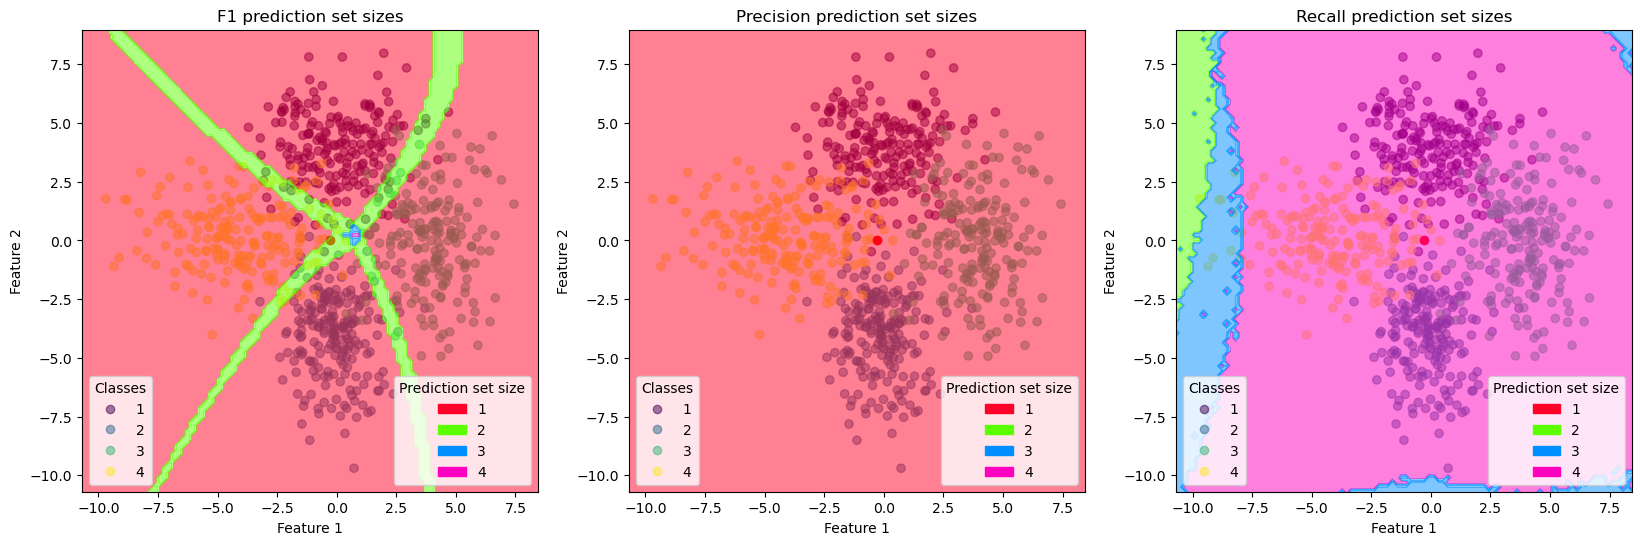

In [16]:
from matplotlib.patches import Patch


def plot_measure_contour(fig, ax, X, y, measure, title):    
    # create all the points we will calculate the prediction set sizes
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    
    x_grid = np.linspace(x_min,x_max, 100)
    y_grid = np.linspace(y_min, y_max, 100)
    
    xv, yv = np.meshgrid(x_grid,y_grid)
    
    points = np.column_stack((xv.ravel(), yv.ravel()))
    
    # calculate set sizes
    set_sizes = list(map(len,build_prediction_set(measure,classes, gaussian_model.predict_proba(points))))
    set_sizes = np.array(set_sizes).reshape(y_grid.shape[0], x_grid.shape[0])    
    
        
    # Build the Discrete Color Map
    cmap = mpl.colormaps["gist_rainbow"]  # define the colormap
    # extract all colors from cmap
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

 
    # define the bins and normalize
    bounds = np.linspace(0, len(classes)+1, len(classes)+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
 
    # plot the data points
    plot_synthetic_data(ax,X,y,x_q,title)

    # create contour plot
    contour = ax.contourf(x_grid, y_grid, set_sizes, alpha=.5,cmap=cmap,norm=norm)

    legend_labels = {
        0:"1",
        1:"2",
        2:"3",
        3:"4"
    }

	# Create legend patches
    patches = [Patch(color=cmap(norm(i+1)), label=label) for i,label in legend_labels.items()]

	# Add the legend with the patches
    legend = ax.legend(handles=patches, loc='lower right',title="Prediction set size",frameon=True)
    
    ax.set_title(title)

          
fig,ax = plt.subplots(nrows=1, ncols=3,figsize=(20,6))

plot_measure_contour(fig,ax[0],X,y,f1_utility_function, "F1 prediction set sizes")
plot_measure_contour(fig,ax[1],X,y,precision_utility_function,"Precision prediction set sizes")
plot_measure_contour(fig,ax[2],X,y,recall_utility_function, "Recall prediction set sizes")
plt.show()

Recall does not build any singleton sets whereas precision only predicts singleton sets. 
The $F_1$-measure balances both recall and precision and constructs all possible sets.
The more uncertainty the model has, i.e., at the overlapping regions the bigger the set become.

<div align="justify">

Other utility functions with specific choices for $g$ are studied in the literature on credal classification {cite:p}`Corani2008NCC,Corani2009LNCC,Zaffalon2012EvaluatingCC,Yang2017b,mpub385`, such as

$$

g_{\delta,\gamma}(s) := \frac{\delta}{s} - \frac{\gamma}{s^2} \,, \quad g_{\exp}(s) := 1- \exp{\left(-\frac{\delta}{s}\right)},   \quad g_{log}(s) := \log \left(1 + \frac{1}{s} \right) \,.

$$

</div>

In [10]:
def delta_gamma_utility_function(delta, gamma):
    def delta_gamma_utility(y,set_prediction):
        def delta_gamma(score):
            return (delta/score) - (gamma/score**2)
        return utility_function(delta_gamma, y, set_prediction)
    return delta_gamma_utility

def exponential_utility_function(delta):
    def exponential_utility(y,set_prediction):
        def exponential_score(score):
            return 1 - np.exp(- delta/score)
        return utility_function(exponential_score,y,set_prediction)
    return exponential_utility

def logarithmic_utility_function(y, set_prediction):
    def logarithmic_score(score):
        return np.log(1 + 1/score)
    return utility_function(logarithmic_score, y , set_prediction)

<div align="justify">

Especially $g_{\delta,\gamma}(s)$ is commonly used in this community, where $\delta$ and $\gamma$ can only take certain values to guarantee that the utility is in the interval $[0,1]$. Precision (here called discounted accuracy) corresponds to the case $(\delta,\gamma)=(1,0)$. However, typical choices for $(\delta,\gamma$) are $(1.6,0.6)$ and $(2.2,1.2)$ {cite:p}`mpub385`, implementing the idea of risk aversion. The measure $g_{\exp}(s)$ is an exponentiated version of precision, where the parameter $\delta$ also defines the degree of risk aversion. 

</div>


In [11]:
delta_16_gamma_06 = delta_gamma_utility_function(1.6, 0.6)
delta_22_gamma_12=  delta_gamma_utility_function(2.2, 1.2)

delta_16_prediction_set = build_prediction_set(delta_16_gamma_06, classes, conditional_probability_query_point)[0]
delta_22_prediction_set = build_prediction_set(delta_22_gamma_12, classes, conditional_probability_query_point)[0]
logarithmic_prediction_set = build_prediction_set(logarithmic_utility_function, classes, conditional_probability_query_point)[0]

print("Prediction set for x_q with delta=1.6 and gamma=0.6: ", delta_16_prediction_set )
print("Prediction set for x_q with delta=2.2 and gamma=1.2: ", delta_22_prediction_set )
print("Prediction set for x_q with logarithmic function: ", logarithmic_prediction_set )

Prediction set for x_q with delta=1.6 and gamma=0.6:  [2 4]
Prediction set for x_q with delta=2.2 and gamma=1.2:  [2 4]
Prediction set for x_q with logarithmic function:  [4]


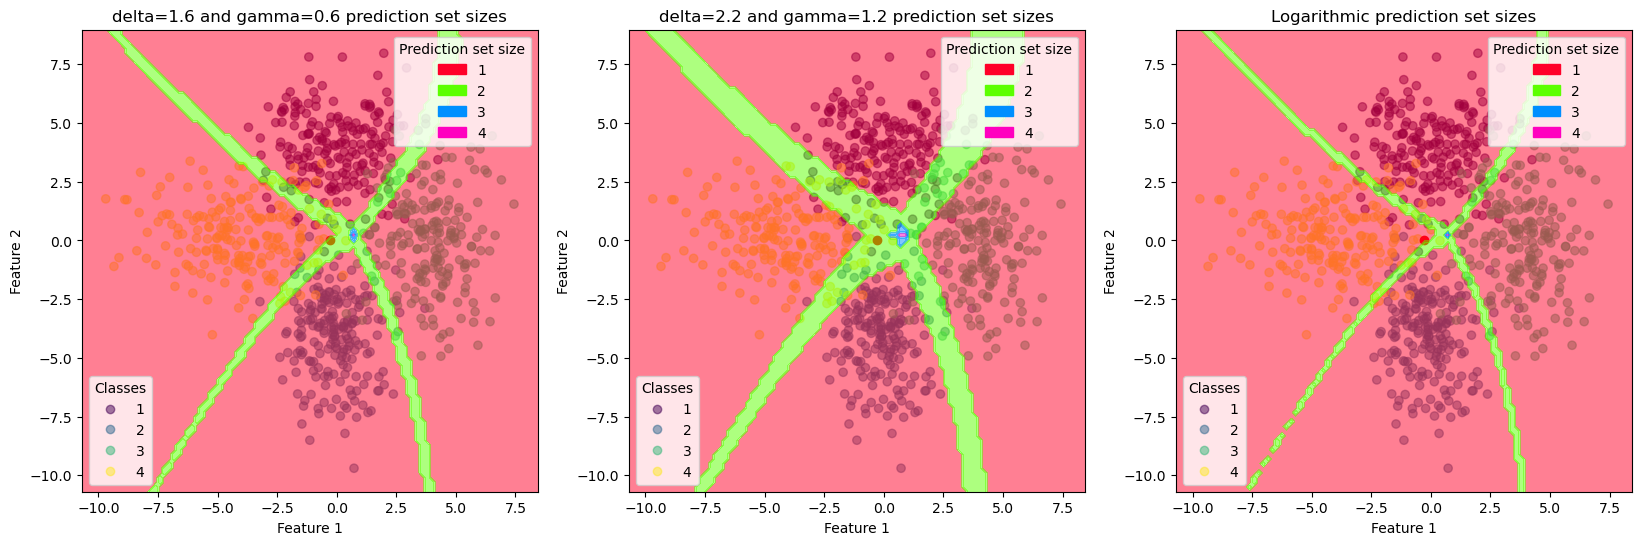

In [12]:
fig,ax = plt.subplots(nrows=1, ncols=3,figsize=(20,6))

plot_measure_contour(fig,ax[0],X,y,delta_16_gamma_06, "delta=1.6 and gamma=0.6 prediction set sizes")
plot_measure_contour(fig,ax[1],X,y,delta_22_gamma_12,"delta=2.2 and gamma=1.2 prediction set sizes")
plot_measure_contour(fig,ax[2],X,y,logarithmic_utility_function, "Logarithmic prediction set sizes")
plt.show()

<div align="justify">


Another example appears in the literature on binary or multi-class classification with reject option {cite:p}`herb_cw06,linu_cw18,Ramaswamy2015CAMCRO`. Here, the prediction can only be a singleton or the full set $\mathcal{Y}$ containing $K$ classes. The first case typically gets a reward of one (if the predicted class is correct), while the second case should receive a lower reward, e.g. $1-\alpha$.  The latter corresponds to abstaining, i.e., not predicting any class label, and the (user-defined) parameter $\alpha$ specifies a penalty for doing so, with the requirement $0< \alpha < 1-1/K$ to be risk-averse. 

</div>

In [13]:
def abstain_utility_function(alpha_value):
    def abstain_utility(y,set_predictions):
        def abstain_score(score):
            if score == 1:
                # because auf utility_function set_predictions == {y}, i.e. only contains y
                return 1
            else:
                return 1-alpha_value
        return utility_function(abstain_score,y, set_predictions)
    return abstain_utility

risk_averse_values = np.linspace(0,1-1/n_classes,4,endpoint=False)[1:] # only valid risk-averse values 0 < alpha < 1 - 1/K

most_risk_averse = abstain_utility_function(risk_averse_values[0]) # is close to 0 thus will be very risk averse
middle_risk_averse= abstain_utility_function(risk_averse_values[1]) # is inbetween 0 and 1 - 1/K
barly_risk_averse = abstain_utility_function(risk_averse_values[2]) # is less risk averse as it is close to 1 - 1/K

biggest_prediction_set = build_prediction_set(most_risk_averse,classes,conditional_probability_query_point)[0]
middle_prediction_set = build_prediction_set(middle_risk_averse,classes,conditional_probability_query_point)[0]
smallest_prediction_set = build_prediction_set(barly_risk_averse,classes,conditional_probability_query_point)[0]
print("Prediction set for x_q with biggest risk-aversity: ", biggest_prediction_set)
print("Prediction set for x_q with middle risk-aversity: ", middle_prediction_set)
print("Prediction set for x_q with low rist-aversity: ", smallest_prediction_set)


Prediction set for x_q with biggest risk-aversity:  [1 2 3 4]
Prediction set for x_q with middle risk-aversity:  [1 2 3 4]
Prediction set for x_q with low rist-aversity:  [4]


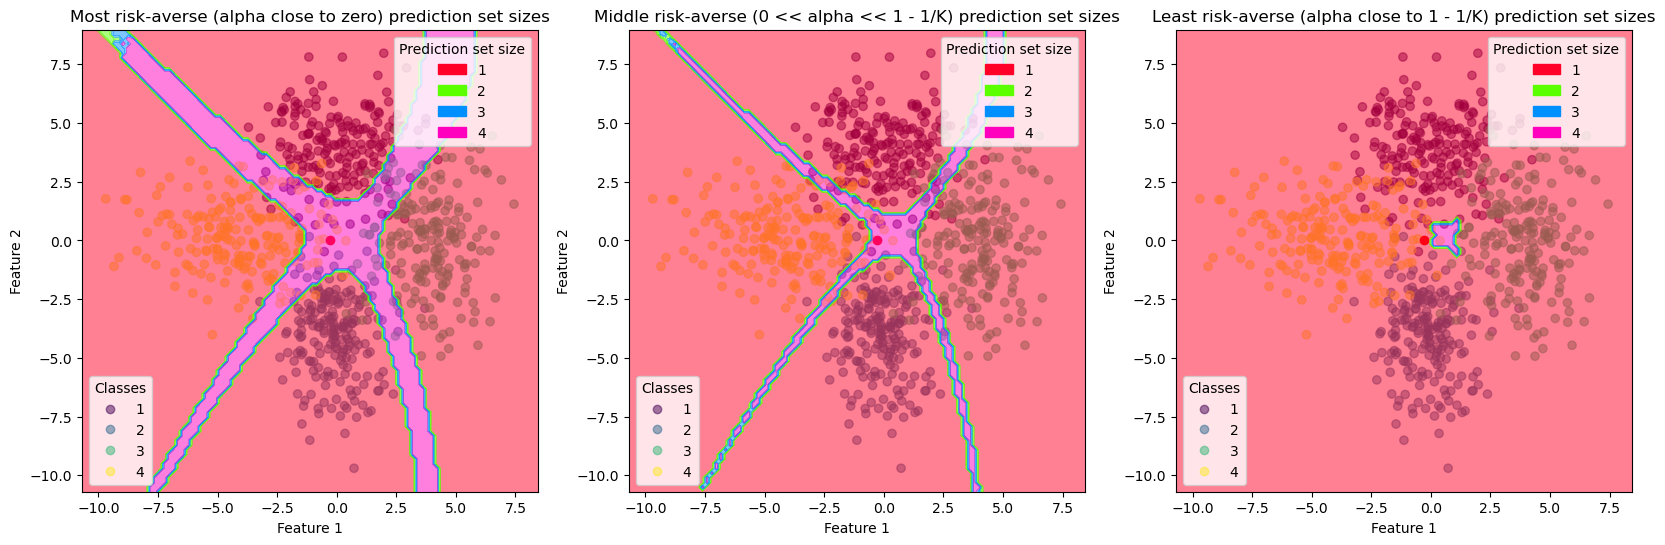

In [14]:
fig,ax = plt.subplots(nrows=1, ncols=3,figsize=(20,6))

plot_measure_contour(fig,ax[0],X,y,most_risk_averse, "Most risk-averse (alpha close to zero) prediction set sizes")
plot_measure_contour(fig,ax[1],X,y,middle_risk_averse,"Middle risk-averse (0 << alpha << 1 - 1/K) prediction set sizes")
plot_measure_contour(fig,ax[2],X,y,barly_risk_averse, "Least risk-averse (alpha close to 1 - 1/K) prediction set sizes")
plt.show()

<div align="justify">

The lower we set our $\alpha$ value the more risk the classifier takes with predicting a single label. Increasing $\alpha$ increases the tendincy to predict the complete set. Setting $\alpha = 0$ would be identical to using recall as utility and $\alpha = 1$ identical to precision (see above figures).

</div>

<div align="justify">

Set-valued predictions are also considered in hierarchical multi-class classification, mostly in the form of internal nodes of the hierarchy  {cite:p}`Freitas_atutorial,Rangwala2017,Yang2017`. Compared to the ''flat'' multi-class case, the prediction space is thus restricted, because only sets of classes that correspond to nodes of the hierarchy can be returned as a prediction. Some of the above utility scores also appear here. For example, \citet{Yang2017} evaluate various members of the $u_{\delta,\gamma}$ family in a framework where hierarchies are considered for computational reasons, while {cite:t}`Oh2017TopKHC` optimizes recall by fixing $|\sety|$ as a user-defined parameter. 
Popular in hierarchical classification is the tree-distance loss, which could also be interpreted as a way of evaluating set-valued predictions {cite:p}`Bi2015`. 
This loss is not a member of the family ({eq}`ufamily`), however. 
Besides, it appears to be a less interesting loss function from the perspective of abstention in cases of uncertainty, since by minimizing the tree distance loss, the classifier will almost never predict leaf nodes of the hierarchy. 
Instead, it will often predict nodes close to the root of the hierarchy, which correspond to sets with many elements\,---\,a behavior that is unfavored if one wants to abstain only in cases of sufficient uncertainty. 

Quite obviously, methods that maximize set-based utility scores are closely connected to the quantification of uncertainty, since the decision about a suitable set of predictions is necessarily derived from information of that kind. The overwhelming majority of the above-mentioned methods depart from conditional class probabilities $p(y \given \vec{x}_q)$ that are estimated in a classical frequentist way, so that uncertainties in decisions are of aleatoric nature. 
Exceptions include {cite:p}`Yang2017` and {cite:p}`mpub385`, who further explore ideas from imprecise probability theory and reliable classification to generate label sets that capture both aleatoric and epistemic uncertainty.   

</div>
